In [ ]:
!pip install -r requirements.txt

In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import HistGradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score ,classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler ,MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [2]:
train_afghanistan = pd.read_csv("train_data_afghanistan.csv")
train_iran_sudan = pd.read_csv("train_data_iran_sudan.csv")

In [3]:
test_afghanistan = pd.read_csv("test_data_afghanistan.csv")
test_iran_sudan = pd.read_csv("test_data_iran_sudan.csv")

In [4]:
combined_train_df = pd.concat([train_afghanistan,train_iran_sudan], axis = 0 )

In [5]:
combined_test_df = pd.concat([test_afghanistan,test_iran_sudan], axis = 0 )

In [6]:
combined_train_df = combined_train_df.dropna(axis= 1)
combined_test_df = combined_test_df.dropna(axis= 1)

In [7]:
combined_train_df = combined_train_df.drop(columns = ['Unnamed: 0'])
combined_test_df = combined_test_df.drop(columns = ['Unnamed: 0'])

In [8]:
combined_train_df = combined_train_df.dropna()

In [9]:
original_train_cols = combined_train_df.columns.to_list()
original_test_cols = combined_test_df.columns.to_list()

In [10]:
combined_train_df.describe()

,Lat,Lon,Target,B1,B2,B3,B4,B5,B7,B8,B8A,B12
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,26.940624,50.708893,0.500000,1987.960102,2049.721367,2260.019563,2344.974213,2712.086615,3410.195133,3498.404887,3480.474036,2296.450040
std,8.941261,15.269588,0.500167,621.674441,607.039694,558.183219,590.798784,531.008524,496.914543,526.988503,482.550430,572.775037
min,14.102382,33.106152,0.000000,50.166667,31.166667,264.166667,171.666667,653.333333,2131.000000,2101.444444,2086.694444,1053.000000
25%,14.441092,33.418070,0.000000,1720.625000,1759.312500,1946.246528,2008.892163,2389.741468,3055.774306,3112.402778,3139.291667,1855.045139
50%,32.251855,48.278068,0.500000,1975.701389,2020.020635,2223.361111,2308.319444,2677.319444,3329.263889,3415.401091,3412.010714,2190.945238
75%,34.120534,70.350163,1.000000,2204.142361,2251.695833,2485.383929,2657.398810,2986.288194,3717.776786,3847.014286,3798.925000,2692.484375
max,34.313253,70.776218,1.000000,5171.916667,6704.666667,6396.000000,6324.000000,5259.833333,5998.833333,6822.333333,5943.000000,3905.666667


In [11]:
combined_test_df.describe()

,Lat,Lon,B1,B2,B3,B4,B5,B7,B8,B8A,B12
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,26.931905,50.744271,2033.215214,2108.666843,2319.372329,2415.714092,2761.967846,3426.921978,3508.898683,3489.163151,2351.201537
std,8.960412,15.249380,625.651006,606.207736,567.148246,608.108358,551.283663,548.411995,585.959086,537.564894,587.570484
min,14.101394,33.103188,51.500000,92.833333,461.833333,299.666667,911.000000,1970.144928,1926.388889,1867.142857,1114.069444
25%,14.392426,33.491103,1664.045139,1738.586806,1972.416667,2050.177419,2413.336806,3014.668403,3071.652778,3086.419841,1895.816468
50%,32.250462,48.412681,2051.047222,2095.124802,2287.541667,2387.041667,2733.664286,3373.416667,3446.892361,3441.813095,2291.798611
75%,34.131326,70.346217,2284.725000,2343.835714,2571.189286,2724.356944,3055.334226,3820.173214,3948.083333,3883.703571,2738.591964
max,34.314178,70.776030,5296.666667,5119.333333,4844.333333,4757.333333,4997.166667,5312.333333,5811.833333,5261.250000,4288.635714


In [12]:
def obtaining_vegetation_indicies(df):
    
    data = df.copy()
    data['ndvi'] = (data['B8'] - data['B4'])/(data['B8'] + data['B4'])
    data['ndvi_n'] = (data['B8A'] - data['B4'])/(data['B8A'] + data['B4'])
    data['ndvi_re'] = (data['B8'] - data['B5'])/(data['B8'] + data['B5'])
    data['ndre_n'] = (data['B8A'] - data['B5'])/(data['B8A'] + data['B5'])
    data['ndi45'] = (data['B5'] - data['B4'])/(data['B5'] + data['B4'])
    data['clg'] = (data['B7'])/(data['B3'] -1)
    data['clre'] = (data['B7'])/(data['B5'] -1)
    data['nbri'] = (data['B8']-data['B12'])/(data['B8']+data['B12'])
    data['evi'] = 2.5 * (data['B8'] - data['B4'])/(data['B8'] + 2.4 * data['B4'] + 1)
    data['gndvi'] = (data['B8'] - data['B3'])/(data['B8']+data['B3'])
    data['simple_ratio'] = (data['B8'])/(data['B3'])

    eps = 0
    data['MMSR'] = ((data['B8']/data['B4']) - 1) / ((data['B8']/data['B4'])**0.5 + 1)
    data['NGRDI'] = ((data['B3'] - data['B4'])/(data['B3'] + data['B4'] + eps))
    data['TGI'] =  data['B3'] - 0.39 * data['B4'] - 0.61 * data['B2']
    data['GCVI'] = ( data['B8'] / (data['B3'] + eps) ) - 1
    data['RGVI'] = 1 - ( (data['B1'] + data['B3']) / (data['B4'] + data['B5'] + data['B7'] + eps) )
    data['ARVI'] =  (data['B8'] - (2 * data['B4']) + data['B2']) / (data['B8'] + (2 * data['B4']) + data['B2'] + eps)
    data['SIPI'] = (data['B8'] - data['B2']) / (data['B8'] - data['B4'] + eps) 
    data['RYI'] = data['B3'] / (data['B2'] + eps)
    data['NDYI'] = (data['B3'] - data['B2']) / (data['B3'] + data['B2'] + eps)
    data['DYI'] = data['B3'] - data['B2']
    data['ACI'] = data['B8'] * (data['B4'] + data['B3'] + eps)
    data['CVI'] = (data['B8'] / (data['B3'] + eps)) * (data['B4'] / (data['B3'] + eps))
    data['AVI'] = (data['B8'] * (1 - data['B4']) * (data['B8'] - data['B4']))
    data['SI'] = ((1 - data['B2']) * (1 - data['B3']) * (1 - data['B4'])) 
    data['SAVI'] = ((data['B8'] - data['B4'])/(data['B8'] + data['B4'] + 0.33)) * (1 + 0.33)  
    data['NPCRI'] = (data['B4'] - data['B2']) / (data['B4'] + data['B2'] + eps)
    data['CCCI'] = ((data['B8'] - data['B5']) / (data['B8'] + data['B5'] + eps)) / ((data['B8'] - data['B4']) / (data['B8'] + data['B4'] + eps)) 
    data['MCARI'] = ((data['B5'] - data['B4']) - 2 * (data['B5'] - data['B3'])) * (data['B5'] / (data['B4'] + eps))  
    data['TCARI'] = 3 * ((data['B5'] - data['B4']) - 0.2 * (data['B5'] - data['B3']) * (data['B5'] / (data['B4'] + eps))) 
    data['PVI'] = (data['B8'] - 0.3 * data['B4'] - 0.5) / ((1 + 0.3 * 2) ** 0.5) 
    data['BAI'] = 1/((0.1 - data['B4']) ** 2 + (0.06 - data['B8']) ** 2)
    data['MTVI2'] = list(1.5*(1.2 * (i - j) - 2.5 * (k - j))* ((2 * i + 1)**2 - (6 * i - 5 * k ** (0.5)) - 0.5)**(0.5) for i, j, k in zip(data['B8'], data['B3'], data['B4']))
    data['CIre'] = ((data['B8'] / (data['B5'] + eps)) - 1)
    data['TNDVI'] = ((data['B8'] - data['B4']) / (data['B8'] + data['B4'] + eps) + 0.5) ** 0.5
    data['VDVI'] = (2 * data['B3'] - data['B4'] - data['B2']) / (2 * data['B3'] + data['B4']  + data['B2'] + eps)
    data['EXG'] = 2 * data['B3'] - data['B4'] - data['B2']


    data['RATIO1'] = data['B1'] / (data['B3'] + eps)
    data['RATIO2'] = data['B1'] / (data['B5'] + eps)
    data['RATIO4'] = data['B5'] / (data['B4'] + eps)
    data['RATIO5'] = data['B7'] / (data['B5'] + eps)
    data['RATIO7'] = data['B8'] / (data['B4'] + eps)
    
    
    data['NDWI'] = (data['B3'] - data['B8']) / (data['B3'] + data['B8'])

    return data
    

In [13]:
train_indices_df = obtaining_vegetation_indicies(combined_train_df)
test_indices_df = obtaining_vegetation_indicies(combined_test_df)


In [14]:
train_indices_df = train_indices_df.drop(original_train_cols,axis =1)
test_indices_df = test_indices_df.drop(original_test_cols,axis =1)

In [15]:
kmeans = KMeans(random_state = 42,n_clusters = 3)
train_indices_df['cluster_3_2nd'] = kmeans.fit_predict(train_indices_df)
test_indices_df['cluster_3_2nd'] = kmeans.predict(test_indices_df)

In [16]:
new_train_df = pd.concat([combined_train_df,train_indices_df],axis = 1)
new_test_df = pd.concat([combined_test_df,test_indices_df],axis = 1)

In [17]:
kmeans = KMeans(random_state = 42,n_clusters = 3)
new_train_df['cluster_3_final'] = kmeans.fit_predict(new_train_df.drop(['ID','Country','Target'],axis=1))
new_test_df['cluster_3_final'] = kmeans.predict(new_test_df.drop(['ID','Country'],axis=1))

In [18]:
new_train_df = new_train_df[~(new_train_df['B1']  <= 500)]
new_train_df = new_train_df[~(new_train_df['B2']  <= 500)]
new_train_df = new_train_df[~(new_train_df['B3']  <= 500)]
new_train_df = new_train_df[~(new_train_df['B4']  <= 500)]

In [19]:
new_train_df.shape

(1473, 59)

In [20]:
new_train_df.describe()

,Lat,Lon,Target,B1,B2,B3,B4,B5,B7,B8,...,VDVI,EXG,RATIO1,RATIO2,RATIO4,RATIO5,RATIO7,NDWI,cluster_3_2nd,cluster_3_final
count,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,...,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000,1473.000000
mean,26.808952,50.341892,0.494908,2017.670052,2078.623026,2285.272806,2370.425992,2734.474376,3413.817062,3501.855734,...,0.015665,121.496595,0.880521,0.734299,1.171525,1.276131,1.554751,-0.214426,0.057026,0.057026
std,8.969320,15.164075,0.500144,586.444332,571.661276,528.375804,561.122380,506.480509,498.852779,529.369782,...,0.018854,121.837943,0.134809,0.135996,0.106578,0.252260,0.482094,0.093013,0.234882,0.234882
min,14.102382,33.106152,0.000000,537.500000,503.666667,860.166667,704.333333,1212.833333,2131.000000,2101.444444,...,-0.052095,-461.166667,0.310335,0.223943,0.831726,0.872041,0.979543,-0.654866,0.000000,0.000000
25%,14.436106,33.399811,0.000000,1742.791667,1771.680556,1966.638889,2029.562500,2412.097222,3056.166667,3111.083333,...,0.004625,41.666667,0.837373,0.674374,1.120956,1.114869,1.283187,-0.256352,0.000000,0.000000
50%,32.247093,48.276002,0.000000,1982.125000,2028.000000,2232.257143,2317.416667,2688.097222,3332.166667,3422.057143,...,0.012126,107.680556,0.896041,0.745012,1.153445,1.224204,1.460582,-0.209899,0.000000,0.000000
75%,34.118787,70.346103,1.000000,2211.152778,2259.242857,2489.621429,2664.583333,2993.514286,3720.107143,3851.000000,...,0.021110,181.271429,0.945503,0.796495,1.193361,1.347114,1.647428,-0.162770,0.000000,0.000000
max,34.313253,70.775452,1.000000,5171.916667,6704.666667,6396.000000,6324.000000,5259.833333,5998.833333,6822.333333,...,0.186153,656.500000,1.590939,1.324727,1.814472,3.543507,6.168748,0.018615,2.000000,2.000000


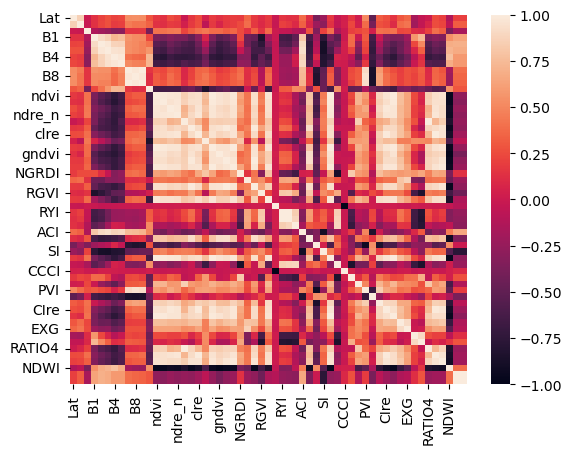

In [21]:
sns.heatmap(new_train_df.corr());

In [22]:
new_train_df = new_train_df.replace([np.inf,-np.inf],np.nan)
new_train_df.fillna(new_train_df.mean(),inplace= True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_7500\3403424589.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  new_train_df.fillna(new_train_df.mean(),inplace= True)


In [23]:
sub = pd.DataFrame()
sub['ID'] = new_test_df['ID']

In [24]:
X = new_train_df.drop(columns = ['Target','ID',])
new_test_df = new_test_df.drop(columns = ['ID',])
y = new_train_df['Target']

In [25]:
le = LabelEncoder()

In [26]:
new_test_df = new_test_df.replace([np.inf,-np.inf],np.nan)
new_test_df.fillna(new_test_df.mean(),inplace= True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_7500\2771718931.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  new_test_df.fillna(new_test_df.mean(),inplace= True)


In [27]:
sc = StandardScaler()
pca = PCA(n_components = 53)

In [28]:
X['Country'] = le.fit_transform(X['Country'])
# xtest['Country'] = le.transform(xtest['Country'])
new_test_df['Country'] = le.transform(new_test_df['Country'])

#### 

In [29]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define the number of folds
n_splits = 10  # You can adjust this as needed

# Initialize the StratifiedKFold cross-validator
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize arrays to store metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
val_fold_predictions = []
test_fold_predictions = []

# Loop over the folds
for train_index, val_index in skf.split(X, y):
    # Split the data into training and validation sets for this fold
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]
    

    X_train = sc.fit_transform(X_train)
    X_val = sc.transform(X_val)
    test_data_scaled = sc.transform(new_test_df)
    
    X_train = pca.fit_transform(X_train)
    X_val = pca.transform(X_val)
    test_data_scaled = pca.transform(test_data_scaled)
    
    from sklearn.utils.class_weight import compute_class_weight
    
    # Initialize and train your classifier
    classifier = HistGradientBoostingClassifier(max_iter = 600, random_state=42)
    classifier.fit(X_train, y_train)

    # Predict on the validation set for this fold
    fold_predictions = classifier.predict(X_val)
    test_predictions = classifier.predict(test_data_scaled)
    
    
    val_fold_predictions.append(fold_predictions)
    test_fold_predictions.append(test_predictions)
    

    # Calculate metrics for this fold and store them
    accuracy_scores.append(accuracy_score(y_val, fold_predictions))
    precision_scores.append(precision_score(y_val, fold_predictions))
    recall_scores.append(recall_score(y_val, fold_predictions))
    f1_scores.append(f1_score(y_val, fold_predictions))
    roc_auc_scores.append(roc_auc_score(y_val, fold_predictions))
    
hist_median_test_predictions = np.median(np.array(test_fold_predictions, dtype = int), axis=0)

# Calculate the mean of each metric across all folds
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)
mean_roc_auc = np.mean(roc_auc_scores)

# Now, mean_accuracy, mean_precision, mean_recall, mean_f1, and mean_roc_auc
# contain the mean values of the respective metrics across all folds.


In [30]:
mean_accuracy,mean_precision,mean_recall,mean_f1,mean_roc_auc

(0.9022706379849236,
 0.891309812537876,
 0.915011415525114,
 0.9025691774438267,
 0.9024606627175121)

In [31]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define the number of folds
n_splits = 10  # You can adjust this as needed

# Initialize the StratifiedKFold cross-validator
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize arrays to store metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
val_fold_predictions = []
test_fold_predictions = []

# Loop over the folds
for train_index, val_index in skf.split(X, y):
    # Split the data into training and validation sets for this fold
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]
    

    X_train = sc.fit_transform(X_train)
    X_val = sc.transform(X_val)
    test_data_scaled = sc.transform(new_test_df)
    
    X_train = pca.fit_transform(X_train)
    X_val = pca.transform(X_val)
    test_data_scaled = pca.transform(test_data_scaled)
    
    from sklearn.utils.class_weight import compute_class_weight
    
    # Initialize and train your classifier
    classifier = LGBMClassifier(n_estimators=550, random_state=42)
    classifier.fit(X_train, y_train)

    # Predict on the validation set for this fold
    fold_predictions = classifier.predict(X_val)
    test_predictions = classifier.predict(test_data_scaled)
    
    
    val_fold_predictions.append(fold_predictions)
    test_fold_predictions.append(test_predictions)
    

    # Calculate metrics for this fold and store them
    accuracy_scores.append(accuracy_score(y_val, fold_predictions))
    precision_scores.append(precision_score(y_val, fold_predictions))
    recall_scores.append(recall_score(y_val, fold_predictions))
    f1_scores.append(f1_score(y_val, fold_predictions))
    roc_auc_scores.append(roc_auc_score(y_val, fold_predictions))
    
lgbm_median_test_predictions = np.median(np.array(test_fold_predictions, dtype = int), axis=0)

# Calculate the mean of each metric across all folds
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)
mean_roc_auc = np.mean(roc_auc_scores)

# Now, mean_accuracy, mean_precision, mean_recall, mean_f1, and mean_roc_auc
# contain the mean values of the respective metrics across all folds.


In [32]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define the number of folds
n_splits = 10  # You can adjust this as needed

# Initialize the StratifiedKFold cross-validator
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize arrays to store metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
val_fold_predictions = []
test_fold_predictions = []

# Loop over the folds
for train_index, val_index in skf.split(X, y):
    # Split the data into training and validation sets for this fold
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]
    

    X_train = sc.fit_transform(X_train)
    X_val = sc.transform(X_val)
    test_data_scaled = sc.transform(new_test_df)
    
    X_train = pca.fit_transform(X_train)
    X_val = pca.transform(X_val)
    test_data_scaled = pca.transform(test_data_scaled)
    
    from sklearn.utils.class_weight import compute_class_weight
    
    # Initialize and train your classifier
    classifier = CatBoostClassifier(iterations=350, random_state=42,verbose = False)
    classifier.fit(X_train, y_train)

    # Predict on the validation set for this fold
    fold_predictions = classifier.predict(X_val)
    test_predictions = classifier.predict(test_data_scaled)
    
    
    val_fold_predictions.append(fold_predictions)
    test_fold_predictions.append(test_predictions)
    

    # Calculate metrics for this fold and store them
    accuracy_scores.append(accuracy_score(y_val, fold_predictions))
    precision_scores.append(precision_score(y_val, fold_predictions))
    recall_scores.append(recall_score(y_val, fold_predictions))
    f1_scores.append(f1_score(y_val, fold_predictions))
    roc_auc_scores.append(roc_auc_score(y_val, fold_predictions))
    
cat_median_test_predictions = np.median(np.array(test_fold_predictions, dtype = int), axis=0)

# Calculate the mean of each metric across all folds
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)
mean_roc_auc = np.mean(roc_auc_scores)

# Now, mean_accuracy, mean_precision, mean_recall, mean_f1, and mean_roc_auc
# contain the mean values of the respective metrics across all folds.


In [33]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Define the number of folds
n_splits = 10  # You can adjust this as needed

# Initialize the StratifiedKFold cross-validator
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize arrays to store metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
val_fold_predictions = []
test_fold_predictions = []

# Loop over the folds
for train_index, val_index in skf.split(X, y):
    # Split the data into training and validation sets for this fold
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_val, y_val = X.iloc[val_index], y.iloc[val_index]
    

    X_train = sc.fit_transform(X_train)
    X_val = sc.transform(X_val)
    test_data_scaled = sc.transform(new_test_df)
    
#     X_train = pca.fit_transform(X_train)
#     X_val = pca.transform(X_val)
#     test_data_scaled = pca.transform(test_data_scaled)
    
    from sklearn.utils.class_weight import compute_class_weight
    
    # Initialize and train your classifier
    classifier = XGBClassifier(n_estimators=550, random_state=42)
    classifier.fit(X_train, y_train)

    # Predict on the validation set for this fold
    fold_predictions = classifier.predict(X_val)
    test_predictions = classifier.predict(test_data_scaled)
    
    
    val_fold_predictions.append(fold_predictions)
    test_fold_predictions.append(test_predictions)
    

    # Calculate metrics for this fold and store them
    accuracy_scores.append(accuracy_score(y_val, fold_predictions))
    precision_scores.append(precision_score(y_val, fold_predictions))
    recall_scores.append(recall_score(y_val, fold_predictions))
    f1_scores.append(f1_score(y_val, fold_predictions))
    roc_auc_scores.append(roc_auc_score(y_val, fold_predictions))
    
xgb_median_test_predictions = np.median(np.array(test_fold_predictions, dtype = int), axis=0)

# Calculate the mean of each metric across all folds
mean_accuracy = np.mean(accuracy_scores)
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)
mean_roc_auc = np.mean(roc_auc_scores)

# Now, mean_accuracy, mean_precision, mean_recall, mean_f1, and mean_roc_auc
# contain the mean values of the respective metrics across all folds.


In [34]:
test_preds = np.median([cat_median_test_predictions,lgbm_median_test_predictions,hist_median_test_predictions,xgb_median_test_predictions],axis=0)

In [35]:
sub['Target'] = test_preds
sub['Target'] = (sub['Target']).astype(int)

In [36]:
sub.to_csv('sub.csv',index = False)

In [37]:
sub['Target'].value_counts()

1    782
0    718
Name: Target, dtype: int64